In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, pred_num:pred_num+1]
train_output.shape

val_output = val_output[:, pred_num:pred_num+1]
val_output.shape

test_output = test_output[:, pred_num:pred_num+1]
test_output.shape

torch.Size([1000, 1])

In [33]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [34]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [35]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [36]:
PATH = 'Auto_No_norm_model_RNA_pro_' + str(pred_num) + '.pth'

In [37]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.4515129  Validation_loss:  0.55636615  Test_loss:  0.28953344


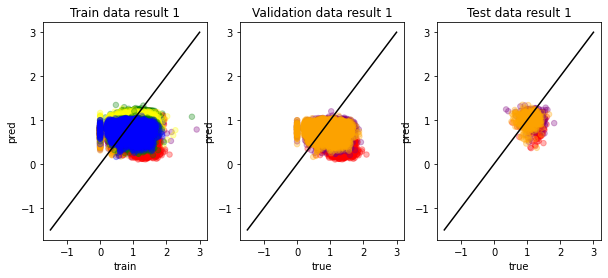

Epoch  100 Train_loss:  0.31675357  Validation_loss:  0.33649093  Test_loss:  0.22679913
Epoch  200 Train_loss:  0.29764482  Validation_loss:  0.30460763  Test_loss:  0.22143817
Epoch  300 Train_loss:  0.28721228  Validation_loss:  0.28884554  Test_loss:  0.21781962
Epoch  400 Train_loss:  0.2807631  Validation_loss:  0.27971387  Test_loss:  0.21668163
Epoch  500 Train_loss:  0.27622023  Validation_loss:  0.27384087  Test_loss:  0.2166853
Epoch  600 Train_loss:  0.27267647  Validation_loss:  0.26988924  Test_loss:  0.21667342
Epoch  700 Train_loss:  0.26969558  Validation_loss:  0.266705  Test_loss:  0.2168859
Epoch  800 Train_loss:  0.26705542  Validation_loss:  0.26387224  Test_loss:  0.2175416
Epoch  900 Train_loss:  0.2646568  Validation_loss:  0.2615526  Test_loss:  0.21785866
Epoch  1000 Train_loss:  0.2624107  Validation_loss:  0.25917032  Test_loss:  0.21860571


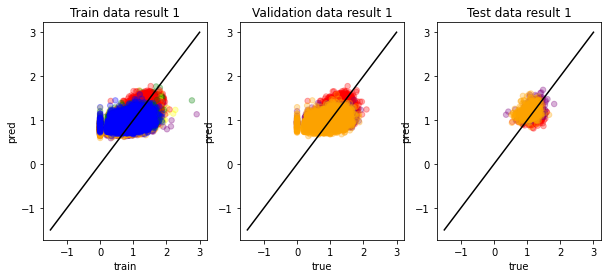

Epoch  1100 Train_loss:  0.26028556  Validation_loss:  0.2570575  Test_loss:  0.21941304
Epoch  1200 Train_loss:  0.25823596  Validation_loss:  0.25496328  Test_loss:  0.220111
Epoch  1300 Train_loss:  0.25623477  Validation_loss:  0.2530358  Test_loss:  0.2207807
Epoch  1400 Train_loss:  0.25425947  Validation_loss:  0.25109836  Test_loss:  0.22152412
Epoch  1500 Train_loss:  0.25230196  Validation_loss:  0.24921237  Test_loss:  0.2222703
Epoch  1600 Train_loss:  0.25033307  Validation_loss:  0.24731892  Test_loss:  0.22306406
Epoch  1700 Train_loss:  0.24835722  Validation_loss:  0.24538909  Test_loss:  0.22410811
Epoch  1800 Train_loss:  0.24636413  Validation_loss:  0.24348156  Test_loss:  0.22467873
Epoch  1900 Train_loss:  0.24433926  Validation_loss:  0.24153756  Test_loss:  0.22555403
Epoch  2000 Train_loss:  0.24227539  Validation_loss:  0.23946178  Test_loss:  0.22688718


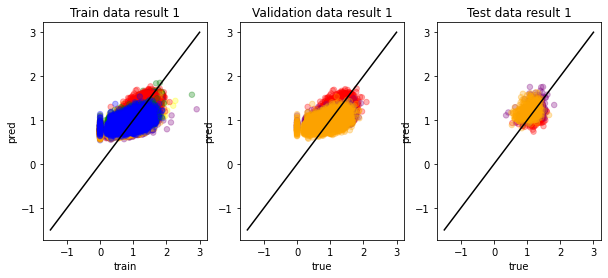

Epoch  2100 Train_loss:  0.24018471  Validation_loss:  0.237454  Test_loss:  0.22769277
Epoch  2200 Train_loss:  0.23805073  Validation_loss:  0.23533118  Test_loss:  0.22903888
Epoch  2300 Train_loss:  0.2358746  Validation_loss:  0.23319815  Test_loss:  0.23027919
Epoch  2400 Train_loss:  0.23365302  Validation_loss:  0.23116489  Test_loss:  0.23067234
Epoch  2500 Train_loss:  0.2313723  Validation_loss:  0.22890833  Test_loss:  0.23207377
Epoch  2600 Train_loss:  0.22904168  Validation_loss:  0.22666322  Test_loss:  0.2331059
Epoch  2700 Train_loss:  0.22666591  Validation_loss:  0.22438471  Test_loss:  0.23403981
Epoch  2800 Train_loss:  0.22422245  Validation_loss:  0.22198538  Test_loss:  0.23542738
Epoch  2900 Train_loss:  0.22173218  Validation_loss:  0.21961913  Test_loss:  0.23639725
Epoch  3000 Train_loss:  0.21918853  Validation_loss:  0.21718943  Test_loss:  0.2373461


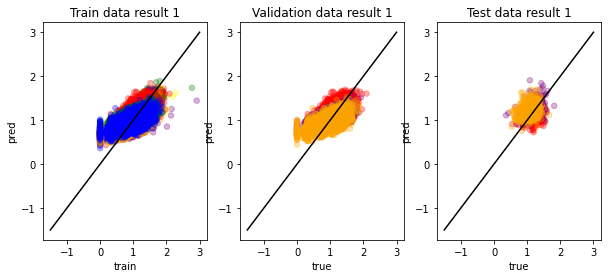

Epoch  3100 Train_loss:  0.21658283  Validation_loss:  0.21465369  Test_loss:  0.2386077
Epoch  3200 Train_loss:  0.21392669  Validation_loss:  0.21206827  Test_loss:  0.2399058
Epoch  3300 Train_loss:  0.21121508  Validation_loss:  0.20943694  Test_loss:  0.24103284
Epoch  3400 Train_loss:  0.20845065  Validation_loss:  0.20667672  Test_loss:  0.24294563
Epoch  3500 Train_loss:  0.20565186  Validation_loss:  0.20407626  Test_loss:  0.2430762
Epoch  3600 Train_loss:  0.20277786  Validation_loss:  0.2012539  Test_loss:  0.24453022
Epoch  3700 Train_loss:  0.19989014  Validation_loss:  0.19849294  Test_loss:  0.2456387
Epoch  3800 Train_loss:  0.19694994  Validation_loss:  0.1955233  Test_loss:  0.24781325
Epoch  3900 Train_loss:  0.19396588  Validation_loss:  0.19273084  Test_loss:  0.24773264
Epoch  4000 Train_loss:  0.19095883  Validation_loss:  0.18984354  Test_loss:  0.24876107


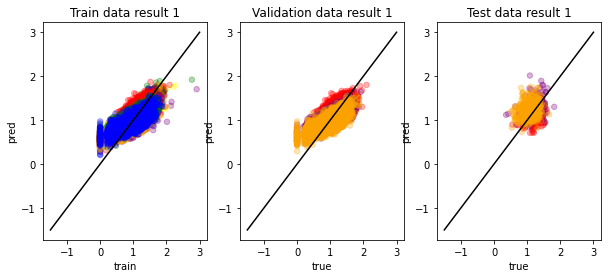

Epoch  4100 Train_loss:  0.18790627  Validation_loss:  0.1868382  Test_loss:  0.2502739
Epoch  4200 Train_loss:  0.18483225  Validation_loss:  0.18387586  Test_loss:  0.25136688
Epoch  4300 Train_loss:  0.1817395  Validation_loss:  0.18082948  Test_loss:  0.2526042
Epoch  4400 Train_loss:  0.17868303  Validation_loss:  0.17800911  Test_loss:  0.25197348
Epoch  4500 Train_loss:  0.175504  Validation_loss:  0.17483531  Test_loss:  0.25408334
Epoch  4600 Train_loss:  0.17235836  Validation_loss:  0.17178568  Test_loss:  0.25476778
Epoch  4700 Train_loss:  0.16920665  Validation_loss:  0.16870548  Test_loss:  0.2561809
Epoch  4800 Train_loss:  0.16605754  Validation_loss:  0.16566348  Test_loss:  0.25712186
Epoch  4900 Train_loss:  0.16291943  Validation_loss:  0.16266358  Test_loss:  0.2574302
Epoch  5000 Train_loss:  0.15980214  Validation_loss:  0.15965936  Test_loss:  0.25780842


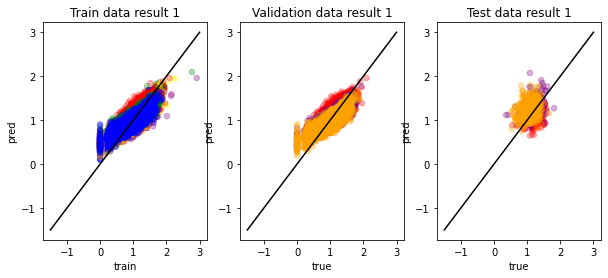

Epoch  5100 Train_loss:  0.15664497  Validation_loss:  0.15659086  Test_loss:  0.2591987
Epoch  5200 Train_loss:  0.15353642  Validation_loss:  0.15358233  Test_loss:  0.2597995
Epoch  5300 Train_loss:  0.15045093  Validation_loss:  0.15050603  Test_loss:  0.26167086
Epoch  5400 Train_loss:  0.14737055  Validation_loss:  0.1476347  Test_loss:  0.26082802
Epoch  5500 Train_loss:  0.14430743  Validation_loss:  0.14460835  Test_loss:  0.26283133
Epoch  5600 Train_loss:  0.14128754  Validation_loss:  0.14167708  Test_loss:  0.2635545
Epoch  5700 Train_loss:  0.13829634  Validation_loss:  0.13886474  Test_loss:  0.2632235
Epoch  5800 Train_loss:  0.13534474  Validation_loss:  0.13590941  Test_loss:  0.26472694
Epoch  5900 Train_loss:  0.13243057  Validation_loss:  0.13314834  Test_loss:  0.26469797
Epoch  6000 Train_loss:  0.1295781  Validation_loss:  0.13042644  Test_loss:  0.26477668


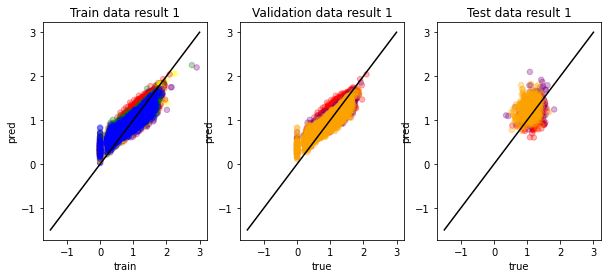

Epoch  6100 Train_loss:  0.12671496  Validation_loss:  0.12761143  Test_loss:  0.2658161
Epoch  6200 Train_loss:  0.12394156  Validation_loss:  0.12490719  Test_loss:  0.2666931
Epoch  6300 Train_loss:  0.12122813  Validation_loss:  0.12232907  Test_loss:  0.26637974
Epoch  6400 Train_loss:  0.11853052  Validation_loss:  0.119694084  Test_loss:  0.2672224
Epoch  6500 Train_loss:  0.11591152  Validation_loss:  0.11713413  Test_loss:  0.26816368
Epoch  6600 Train_loss:  0.11332334  Validation_loss:  0.11467052  Test_loss:  0.26800236
Epoch  6700 Train_loss:  0.110803954  Validation_loss:  0.11222823  Test_loss:  0.2682576
Epoch  6800 Train_loss:  0.10838371  Validation_loss:  0.10992967  Test_loss:  0.2681438
Epoch  6900 Train_loss:  0.10592802  Validation_loss:  0.10746478  Test_loss:  0.2694309
Epoch  7000 Train_loss:  0.10358162  Validation_loss:  0.10521716  Test_loss:  0.26924473


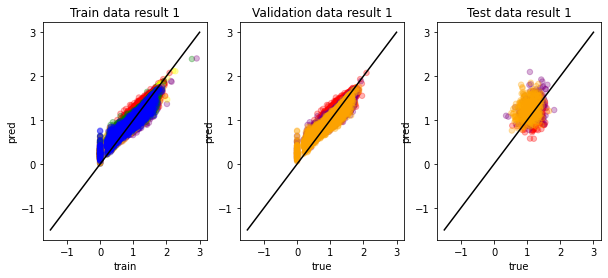

Epoch  7100 Train_loss:  0.1013284  Validation_loss:  0.10308592  Test_loss:  0.26865584
Epoch  7200 Train_loss:  0.099026434  Validation_loss:  0.10080034  Test_loss:  0.26998973
Epoch  7300 Train_loss:  0.09684612  Validation_loss:  0.09869508  Test_loss:  0.270168
Epoch  7400 Train_loss:  0.09470839  Validation_loss:  0.096648514  Test_loss:  0.27007946
Epoch  7500 Train_loss:  0.092644624  Validation_loss:  0.094631955  Test_loss:  0.27062428
Epoch  7600 Train_loss:  0.0906192  Validation_loss:  0.09263399  Test_loss:  0.27147534
Epoch  7700 Train_loss:  0.08863952  Validation_loss:  0.09076878  Test_loss:  0.27113914
Epoch  7800 Train_loss:  0.08669486  Validation_loss:  0.088857755  Test_loss:  0.27153966
Epoch  7900 Train_loss:  0.08485922  Validation_loss:  0.087064885  Test_loss:  0.27150244
Epoch  8000 Train_loss:  0.08303648  Validation_loss:  0.08530975  Test_loss:  0.27158552


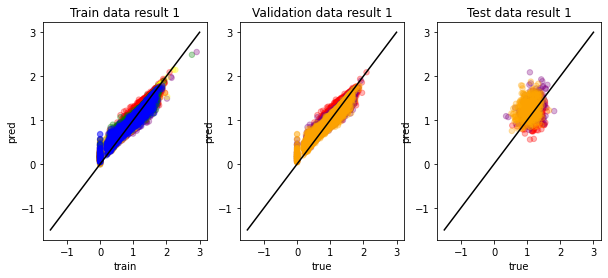

Epoch  8100 Train_loss:  0.08131084  Validation_loss:  0.083661705  Test_loss:  0.27112648
Epoch  8200 Train_loss:  0.07957139  Validation_loss:  0.0819597  Test_loss:  0.27175614
Epoch  8300 Train_loss:  0.07792456  Validation_loss:  0.080325104  Test_loss:  0.27235135
Epoch  8400 Train_loss:  0.076352306  Validation_loss:  0.078798816  Test_loss:  0.2717927
Epoch  8500 Train_loss:  0.07478051  Validation_loss:  0.0772214  Test_loss:  0.27280137
Epoch  8600 Train_loss:  0.07323448  Validation_loss:  0.075738996  Test_loss:  0.27290758
Epoch  8700 Train_loss:  0.07182677  Validation_loss:  0.07431099  Test_loss:  0.2733822
Epoch  8800 Train_loss:  0.07034873  Validation_loss:  0.07293835  Test_loss:  0.2722909
Epoch  8900 Train_loss:  0.069038525  Validation_loss:  0.07169934  Test_loss:  0.27167147
Epoch  9000 Train_loss:  0.0676485  Validation_loss:  0.0702024  Test_loss:  0.27355272


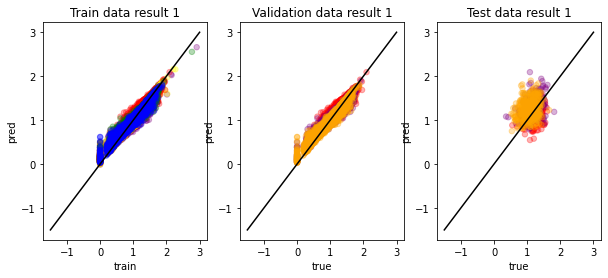

Epoch  9100 Train_loss:  0.06632132  Validation_loss:  0.06893841  Test_loss:  0.27289262
Epoch  9200 Train_loss:  0.065037705  Validation_loss:  0.067698665  Test_loss:  0.2726614
Epoch  9300 Train_loss:  0.06384453  Validation_loss:  0.06650574  Test_loss:  0.2726003
Epoch  9400 Train_loss:  0.062609345  Validation_loss:  0.065279774  Test_loss:  0.27341163
Epoch  9500 Train_loss:  0.06148591  Validation_loss:  0.06419585  Test_loss:  0.27229092
Epoch  9600 Train_loss:  0.060360014  Validation_loss:  0.06301941  Test_loss:  0.27359015
Epoch  9700 Train_loss:  0.059281487  Validation_loss:  0.06195078  Test_loss:  0.27343735
Epoch  9800 Train_loss:  0.058253136  Validation_loss:  0.060970135  Test_loss:  0.2726575
Epoch  9900 Train_loss:  0.05714571  Validation_loss:  0.059858616  Test_loss:  0.27331668
Epoch  10000 Train_loss:  0.056238487  Validation_loss:  0.058983  Test_loss:  0.2722971


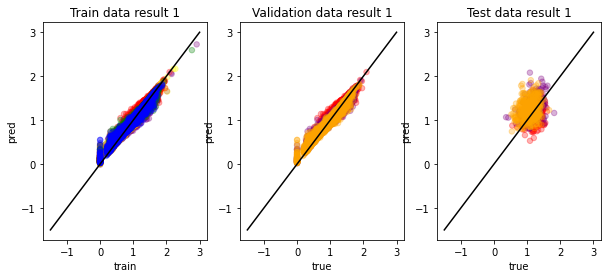

Epoch  10100 Train_loss:  0.055192534  Validation_loss:  0.057911813  Test_loss:  0.27294078
Epoch  10200 Train_loss:  0.054269105  Validation_loss:  0.057007156  Test_loss:  0.27278987
Epoch  10300 Train_loss:  0.053356536  Validation_loss:  0.056046054  Test_loss:  0.27306935
Epoch  10400 Train_loss:  0.052437183  Validation_loss:  0.05512973  Test_loss:  0.2729869
Epoch  10500 Train_loss:  0.05169944  Validation_loss:  0.05440357  Test_loss:  0.27199322
Epoch  10600 Train_loss:  0.050742514  Validation_loss:  0.05343708  Test_loss:  0.27295274
Epoch  10700 Train_loss:  0.049947668  Validation_loss:  0.052595276  Test_loss:  0.27359265
Epoch  10800 Train_loss:  0.04920393  Validation_loss:  0.051889572  Test_loss:  0.27229998
Epoch  10900 Train_loss:  0.04851638  Validation_loss:  0.051215257  Test_loss:  0.27201924
Epoch  11000 Train_loss:  0.04765277  Validation_loss:  0.050307862  Test_loss:  0.27242252


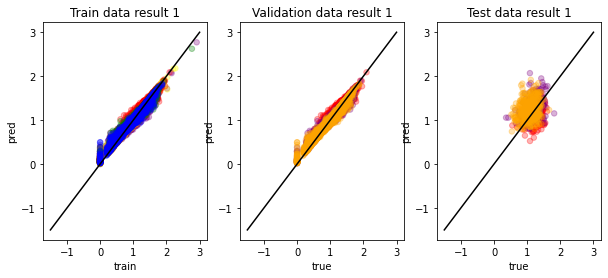

Epoch  11100 Train_loss:  0.0468653  Validation_loss:  0.04948004  Test_loss:  0.2730947
Epoch  11200 Train_loss:  0.04612263  Validation_loss:  0.04875778  Test_loss:  0.27290073
Epoch  11300 Train_loss:  0.04550733  Validation_loss:  0.048132237  Test_loss:  0.2728212
Epoch  11400 Train_loss:  0.04480016  Validation_loss:  0.04736077  Test_loss:  0.2732429
Epoch  11500 Train_loss:  0.04414144  Validation_loss:  0.04671294  Test_loss:  0.2730025
Epoch  11600 Train_loss:  0.04345372  Validation_loss:  0.046003547  Test_loss:  0.2730084
Epoch  11700 Train_loss:  0.042879876  Validation_loss:  0.045391083  Test_loss:  0.27301952
Epoch  11800 Train_loss:  0.042281426  Validation_loss:  0.04474667  Test_loss:  0.27365905
Epoch  11900 Train_loss:  0.041699994  Validation_loss:  0.04419583  Test_loss:  0.27276522
Epoch  12000 Train_loss:  0.041081786  Validation_loss:  0.043574695  Test_loss:  0.27289963


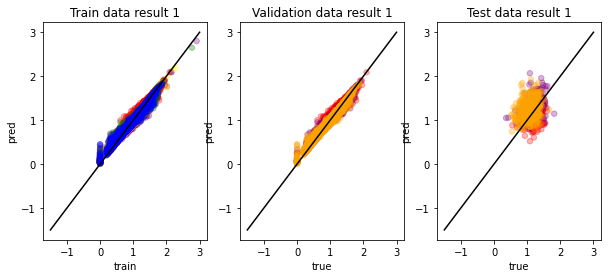

Epoch  12100 Train_loss:  0.040540587  Validation_loss:  0.042960048  Test_loss:  0.27368215
Epoch  12200 Train_loss:  0.040067557  Validation_loss:  0.04254253  Test_loss:  0.272546
Epoch  12300 Train_loss:  0.039436456  Validation_loss:  0.04184207  Test_loss:  0.27278367
Epoch  12400 Train_loss:  0.038984332  Validation_loss:  0.041371696  Test_loss:  0.27233386
Epoch  12500 Train_loss:  0.038433675  Validation_loss:  0.04080985  Test_loss:  0.27238673
Epoch  12600 Train_loss:  0.037921578  Validation_loss:  0.040336747  Test_loss:  0.2728429
Epoch  12700 Train_loss:  0.03755852  Validation_loss:  0.039887104  Test_loss:  0.2721628
Epoch  12800 Train_loss:  0.036998  Validation_loss:  0.03929699  Test_loss:  0.272766
Epoch  12900 Train_loss:  0.036607083  Validation_loss:  0.03893511  Test_loss:  0.27216426
Epoch  13000 Train_loss:  0.036322437  Validation_loss:  0.03866011  Test_loss:  0.27180323


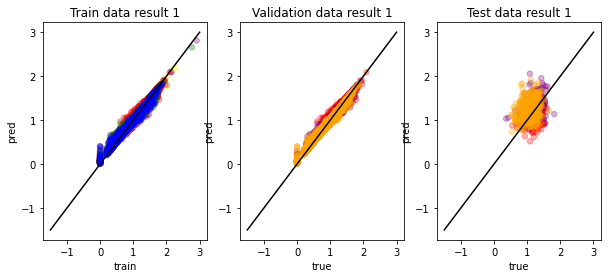

Epoch  13100 Train_loss:  0.035774443  Validation_loss:  0.037907597  Test_loss:  0.2741601
Epoch  13200 Train_loss:  0.0352384  Validation_loss:  0.037465546  Test_loss:  0.27224484
Epoch  13300 Train_loss:  0.0347999  Validation_loss:  0.036996268  Test_loss:  0.2728985
Epoch  13400 Train_loss:  0.03442729  Validation_loss:  0.036572702  Test_loss:  0.27197236
Epoch  13500 Train_loss:  0.034031525  Validation_loss:  0.036135193  Test_loss:  0.272317
Epoch  13600 Train_loss:  0.033694226  Validation_loss:  0.0358434  Test_loss:  0.27213523
Epoch  13700 Train_loss:  0.03328727  Validation_loss:  0.035355926  Test_loss:  0.27246383
Epoch  13800 Train_loss:  0.03292805  Validation_loss:  0.035081666  Test_loss:  0.2719191
Epoch  13900 Train_loss:  0.03251624  Validation_loss:  0.0345799  Test_loss:  0.27197173
Epoch  14000 Train_loss:  0.032238718  Validation_loss:  0.034296177  Test_loss:  0.27194855


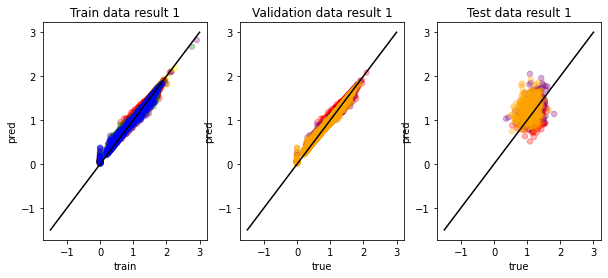

Epoch  14100 Train_loss:  0.031868357  Validation_loss:  0.03387299  Test_loss:  0.2722279
Epoch  14200 Train_loss:  0.031549253  Validation_loss:  0.03350412  Test_loss:  0.2715495
Epoch  14300 Train_loss:  0.031133339  Validation_loss:  0.03309481  Test_loss:  0.2722167
Epoch  14400 Train_loss:  0.030889457  Validation_loss:  0.03281339  Test_loss:  0.27160645
Epoch  14500 Train_loss:  0.030503869  Validation_loss:  0.032419156  Test_loss:  0.27222484
Epoch  14600 Train_loss:  0.03011395  Validation_loss:  0.031990547  Test_loss:  0.2720938
Epoch  14700 Train_loss:  0.02988543  Validation_loss:  0.031754807  Test_loss:  0.27173647
Epoch  14800 Train_loss:  0.029643942  Validation_loss:  0.031532273  Test_loss:  0.27140605
Epoch  14900 Train_loss:  0.029232096  Validation_loss:  0.031032778  Test_loss:  0.27184373
Epoch  15000 Train_loss:  0.028946934  Validation_loss:  0.030713733  Test_loss:  0.27173802


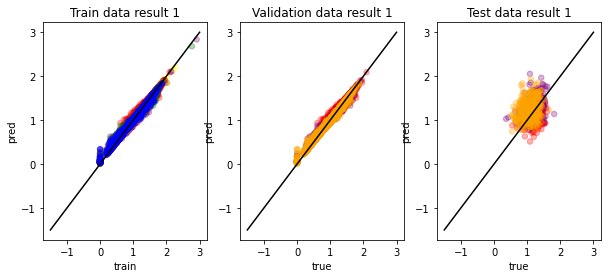

Epoch  15100 Train_loss:  0.028656688  Validation_loss:  0.030459944  Test_loss:  0.27175215
Epoch  15200 Train_loss:  0.02850332  Validation_loss:  0.030272564  Test_loss:  0.27104288
Epoch  15300 Train_loss:  0.028211307  Validation_loss:  0.029965796  Test_loss:  0.27150568
Epoch  15400 Train_loss:  0.027902309  Validation_loss:  0.029630344  Test_loss:  0.27152517
Epoch  15500 Train_loss:  0.02768113  Validation_loss:  0.029377488  Test_loss:  0.27096748
Epoch  15600 Train_loss:  0.027350994  Validation_loss:  0.029026968  Test_loss:  0.27096024
Epoch  15700 Train_loss:  0.027142521  Validation_loss:  0.02876045  Test_loss:  0.2718299
Epoch  15800 Train_loss:  0.026893819  Validation_loss:  0.028485162  Test_loss:  0.27163842
Epoch  15900 Train_loss:  0.026743157  Validation_loss:  0.028402152  Test_loss:  0.2709935
Epoch  16000 Train_loss:  0.026412062  Validation_loss:  0.027969277  Test_loss:  0.27190915


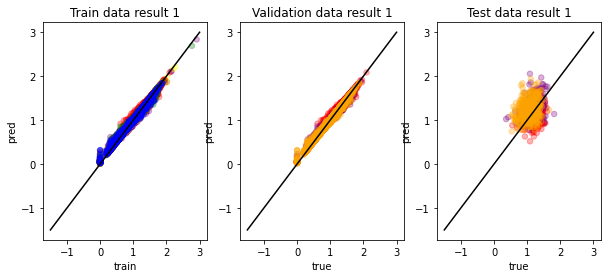

Epoch  16100 Train_loss:  0.026243633  Validation_loss:  0.027739415  Test_loss:  0.27190122
Epoch  16200 Train_loss:  0.026015967  Validation_loss:  0.027603868  Test_loss:  0.27085197
Epoch  16300 Train_loss:  0.025745433  Validation_loss:  0.027204597  Test_loss:  0.2716703
Epoch  16400 Train_loss:  0.025531117  Validation_loss:  0.027004762  Test_loss:  0.2716992
Epoch  16500 Train_loss:  0.025438027  Validation_loss:  0.026966954  Test_loss:  0.27005315
Epoch  16600 Train_loss:  0.025080679  Validation_loss:  0.026563745  Test_loss:  0.2708829
Epoch  16700 Train_loss:  0.024827717  Validation_loss:  0.026268043  Test_loss:  0.27083588
Epoch  16800 Train_loss:  0.024669584  Validation_loss:  0.026097354  Test_loss:  0.27087304
Epoch  16900 Train_loss:  0.024448927  Validation_loss:  0.025838938  Test_loss:  0.27083573
Epoch  17000 Train_loss:  0.024229288  Validation_loss:  0.02561055  Test_loss:  0.2712018


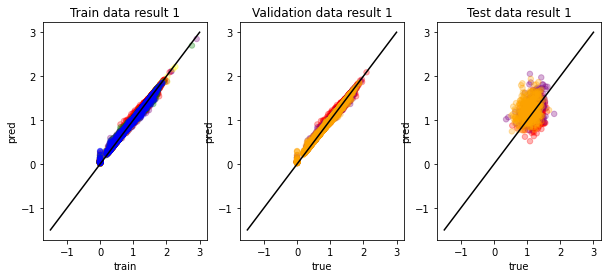

Epoch  17100 Train_loss:  0.024111845  Validation_loss:  0.025473535  Test_loss:  0.27013162
Epoch  17200 Train_loss:  0.023933852  Validation_loss:  0.025209723  Test_loss:  0.27132067
Epoch  17300 Train_loss:  0.023748022  Validation_loss:  0.025115391  Test_loss:  0.27014583
Epoch  17400 Train_loss:  0.023530366  Validation_loss:  0.0247987  Test_loss:  0.2708598
Epoch  17500 Train_loss:  0.023375139  Validation_loss:  0.02472139  Test_loss:  0.27005646
Epoch  17600 Train_loss:  0.02321614  Validation_loss:  0.024534067  Test_loss:  0.2702493
Epoch  17700 Train_loss:  0.02290995  Validation_loss:  0.024203185  Test_loss:  0.27005935
Epoch  17800 Train_loss:  0.022877753  Validation_loss:  0.024161033  Test_loss:  0.2695774
Epoch  17900 Train_loss:  0.02256374  Validation_loss:  0.023814691  Test_loss:  0.27030364
Epoch  18000 Train_loss:  0.022540515  Validation_loss:  0.023731127  Test_loss:  0.269914


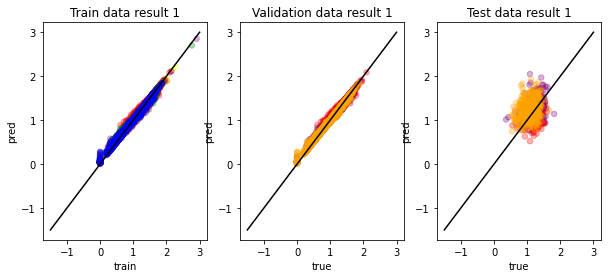

Epoch  18100 Train_loss:  0.022413548  Validation_loss:  0.023601828  Test_loss:  0.27031752
Epoch  18200 Train_loss:  0.02222205  Validation_loss:  0.023448775  Test_loss:  0.2693758
Epoch  18300 Train_loss:  0.02202459  Validation_loss:  0.023175439  Test_loss:  0.27005515
Epoch  18400 Train_loss:  0.021849396  Validation_loss:  0.023035452  Test_loss:  0.26945522
Epoch  18500 Train_loss:  0.02164592  Validation_loss:  0.022814399  Test_loss:  0.26981473
Epoch  18600 Train_loss:  0.021546554  Validation_loss:  0.02267254  Test_loss:  0.2698052
Epoch  18700 Train_loss:  0.021424457  Validation_loss:  0.022497864  Test_loss:  0.2696978
Epoch  18800 Train_loss:  0.021369876  Validation_loss:  0.022521911  Test_loss:  0.26910985
Epoch  18900 Train_loss:  0.02100522  Validation_loss:  0.022096938  Test_loss:  0.26982388
Epoch  19000 Train_loss:  0.021011917  Validation_loss:  0.022102306  Test_loss:  0.26938736


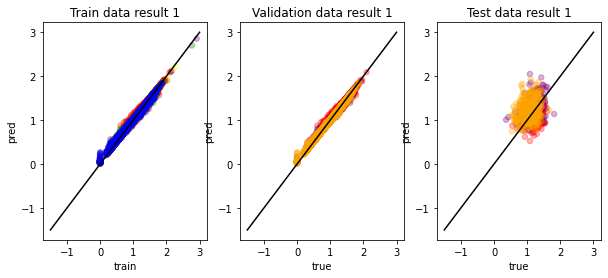

Epoch  19100 Train_loss:  0.020935683  Validation_loss:  0.022059824  Test_loss:  0.26927087
Epoch  19200 Train_loss:  0.020701796  Validation_loss:  0.0217937  Test_loss:  0.26915807
Epoch  19300 Train_loss:  0.020618986  Validation_loss:  0.02164304  Test_loss:  0.26917586
Epoch  19400 Train_loss:  0.02050821  Validation_loss:  0.021598592  Test_loss:  0.2687593
Epoch  19500 Train_loss:  0.020344894  Validation_loss:  0.021361455  Test_loss:  0.268759
Epoch  19600 Train_loss:  0.020227103  Validation_loss:  0.021248229  Test_loss:  0.26920635
Epoch  19700 Train_loss:  0.02000498  Validation_loss:  0.020991217  Test_loss:  0.2689435
Epoch  19800 Train_loss:  0.020045403  Validation_loss:  0.0210644  Test_loss:  0.2683851
Epoch  19900 Train_loss:  0.019876547  Validation_loss:  0.020812972  Test_loss:  0.2689622
Epoch  20000 Train_loss:  0.019771354  Validation_loss:  0.020736063  Test_loss:  0.26849815


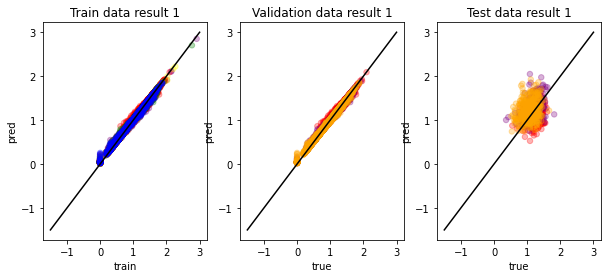

Epoch  20100 Train_loss:  0.019759852  Validation_loss:  0.02073612  Test_loss:  0.26787242
Epoch  20200 Train_loss:  0.019613981  Validation_loss:  0.020614376  Test_loss:  0.26801747
Epoch  20300 Train_loss:  0.019309927  Validation_loss:  0.020262213  Test_loss:  0.2685643
Epoch  20400 Train_loss:  0.019272624  Validation_loss:  0.020196889  Test_loss:  0.26797068
Epoch  20500 Train_loss:  0.019214898  Validation_loss:  0.020169565  Test_loss:  0.26823613
Epoch  20600 Train_loss:  0.018979337  Validation_loss:  0.01983543  Test_loss:  0.26870054
Epoch  20700 Train_loss:  0.018868413  Validation_loss:  0.019787792  Test_loss:  0.26824817
Epoch  20800 Train_loss:  0.018812023  Validation_loss:  0.019647893  Test_loss:  0.26833475
Epoch  20900 Train_loss:  0.018968498  Validation_loss:  0.019901648  Test_loss:  0.26728532
Epoch  21000 Train_loss:  0.018565267  Validation_loss:  0.019409178  Test_loss:  0.26809597


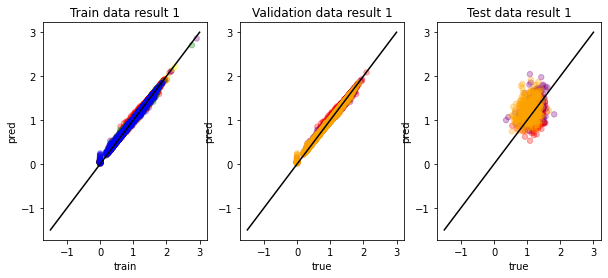

Epoch  21100 Train_loss:  0.018652784  Validation_loss:  0.019507537  Test_loss:  0.26751983
Epoch  21200 Train_loss:  0.018397348  Validation_loss:  0.01921148  Test_loss:  0.26805964
Epoch  21300 Train_loss:  0.018308833  Validation_loss:  0.019098869  Test_loss:  0.26803854
Epoch  21400 Train_loss:  0.018254094  Validation_loss:  0.019127116  Test_loss:  0.26760706
Epoch  21500 Train_loss:  0.018105598  Validation_loss:  0.0188784  Test_loss:  0.26765543
Epoch  21600 Train_loss:  0.018078083  Validation_loss:  0.018853579  Test_loss:  0.26798353
Epoch  21700 Train_loss:  0.017921356  Validation_loss:  0.018682135  Test_loss:  0.2673544
Epoch  21800 Train_loss:  0.017786428  Validation_loss:  0.018507184  Test_loss:  0.26772967
Epoch  21900 Train_loss:  0.017737145  Validation_loss:  0.018534286  Test_loss:  0.26719415
Epoch  22000 Train_loss:  0.017735118  Validation_loss:  0.018467968  Test_loss:  0.2674331


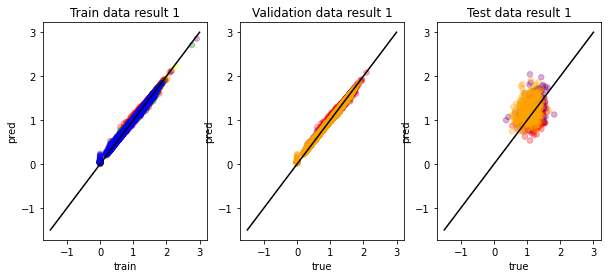

Epoch  22100 Train_loss:  0.017508285  Validation_loss:  0.018258002  Test_loss:  0.2670871
Epoch  22200 Train_loss:  0.017552596  Validation_loss:  0.018259518  Test_loss:  0.2672217
Epoch  22300 Train_loss:  0.017425725  Validation_loss:  0.01815662  Test_loss:  0.26692578
Epoch  22400 Train_loss:  0.017421877  Validation_loss:  0.018132113  Test_loss:  0.2668093
Epoch  22500 Train_loss:  0.017302426  Validation_loss:  0.017961105  Test_loss:  0.2671612
Epoch  22600 Train_loss:  0.017148882  Validation_loss:  0.017886  Test_loss:  0.2669026
Epoch  22700 Train_loss:  0.01705062  Validation_loss:  0.017679373  Test_loss:  0.26750633
Epoch  22800 Train_loss:  0.016999364  Validation_loss:  0.017637324  Test_loss:  0.26681748
Epoch  22900 Train_loss:  0.016865116  Validation_loss:  0.017552271  Test_loss:  0.26672545
Epoch  23000 Train_loss:  0.016834682  Validation_loss:  0.017500417  Test_loss:  0.26645204


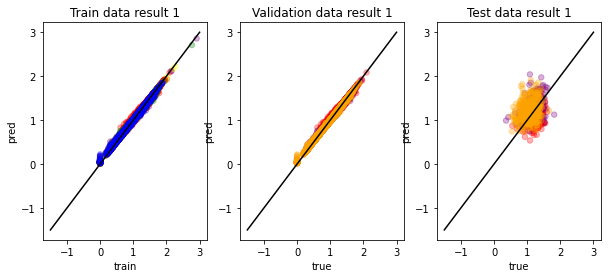

Epoch  23100 Train_loss:  0.016866358  Validation_loss:  0.017585889  Test_loss:  0.26612914
Epoch  23200 Train_loss:  0.016692689  Validation_loss:  0.017356586  Test_loss:  0.26659316
Epoch  23300 Train_loss:  0.016538745  Validation_loss:  0.017213378  Test_loss:  0.2666325
Epoch  23400 Train_loss:  0.016479287  Validation_loss:  0.017130636  Test_loss:  0.26613554
Epoch  23500 Train_loss:  0.016256517  Validation_loss:  0.016896494  Test_loss:  0.26623422
Epoch  23600 Train_loss:  0.016463503  Validation_loss:  0.017131913  Test_loss:  0.26597598
Epoch  23700 Train_loss:  0.016254429  Validation_loss:  0.016857553  Test_loss:  0.26625255
Epoch  23800 Train_loss:  0.016036173  Validation_loss:  0.016660767  Test_loss:  0.2663946
Epoch  23900 Train_loss:  0.016050251  Validation_loss:  0.01662864  Test_loss:  0.26667127
Epoch  24000 Train_loss:  0.016155563  Validation_loss:  0.01674876  Test_loss:  0.26609167


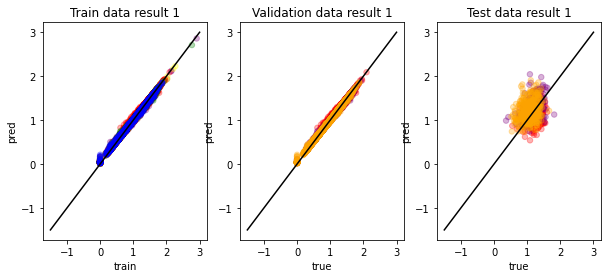

Epoch  24100 Train_loss:  0.015985563  Validation_loss:  0.016570618  Test_loss:  0.2661883
Epoch  24200 Train_loss:  0.015846943  Validation_loss:  0.016433025  Test_loss:  0.2659819
Epoch  24300 Train_loss:  0.015904758  Validation_loss:  0.016463323  Test_loss:  0.26611856
Epoch  24400 Train_loss:  0.015932687  Validation_loss:  0.016500317  Test_loss:  0.2658262
Epoch  24500 Train_loss:  0.015725747  Validation_loss:  0.016211763  Test_loss:  0.26669455
Epoch  24600 Train_loss:  0.015703946  Validation_loss:  0.016229818  Test_loss:  0.26589698
Epoch  24700 Train_loss:  0.0155722  Validation_loss:  0.016100457  Test_loss:  0.2657682
Epoch  24800 Train_loss:  0.01574947  Validation_loss:  0.01619523  Test_loss:  0.26606938
Epoch  24900 Train_loss:  0.015607093  Validation_loss:  0.01605599  Test_loss:  0.26613894
Epoch  25000 Train_loss:  0.015411676  Validation_loss:  0.016001603  Test_loss:  0.26552528


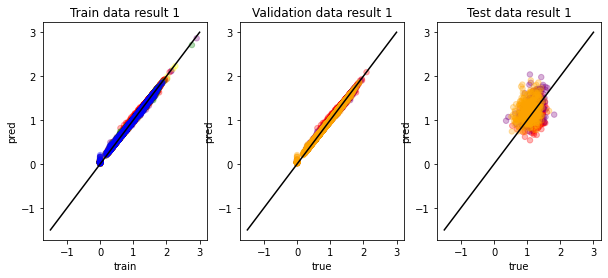

Epoch  25100 Train_loss:  0.015396941  Validation_loss:  0.015933795  Test_loss:  0.2657981
Epoch  25200 Train_loss:  0.015360343  Validation_loss:  0.015868993  Test_loss:  0.26554826
Epoch  25300 Train_loss:  0.015342907  Validation_loss:  0.015840685  Test_loss:  0.26546016
Epoch  25400 Train_loss:  0.015173669  Validation_loss:  0.015667818  Test_loss:  0.265183
Epoch  25500 Train_loss:  0.014911719  Validation_loss:  0.015422954  Test_loss:  0.26541403
Epoch  25600 Train_loss:  0.015141308  Validation_loss:  0.0155874295  Test_loss:  0.26524413
Epoch  25700 Train_loss:  0.015084791  Validation_loss:  0.015551929  Test_loss:  0.26525363
Epoch  25800 Train_loss:  0.015071626  Validation_loss:  0.015587324  Test_loss:  0.26469842
Epoch  25900 Train_loss:  0.014872871  Validation_loss:  0.015317083  Test_loss:  0.26528788
Epoch  26000 Train_loss:  0.014817751  Validation_loss:  0.015356932  Test_loss:  0.26517874


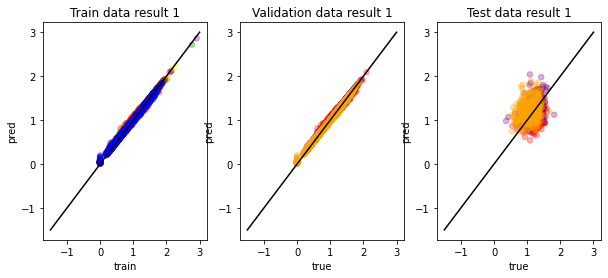

Epoch  26100 Train_loss:  0.014832514  Validation_loss:  0.015286925  Test_loss:  0.2647159
Epoch  26200 Train_loss:  0.0146246655  Validation_loss:  0.015090286  Test_loss:  0.26504666
Epoch  26300 Train_loss:  0.014774714  Validation_loss:  0.015231839  Test_loss:  0.26499176
Epoch  26400 Train_loss:  0.014635582  Validation_loss:  0.015043948  Test_loss:  0.265181
Epoch  26500 Train_loss:  0.01455719  Validation_loss:  0.014972533  Test_loss:  0.26467836
Epoch  26600 Train_loss:  0.014454928  Validation_loss:  0.014893768  Test_loss:  0.2647507
Epoch  26700 Train_loss:  0.01454358  Validation_loss:  0.014992936  Test_loss:  0.26449937
Epoch  26800 Train_loss:  0.014351674  Validation_loss:  0.0147619  Test_loss:  0.26485944
Epoch  26900 Train_loss:  0.014386501  Validation_loss:  0.014800984  Test_loss:  0.26443958
Epoch  27000 Train_loss:  0.01434616  Validation_loss:  0.014734719  Test_loss:  0.26447454


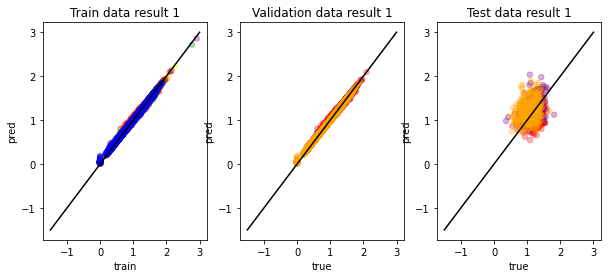

Epoch  27100 Train_loss:  0.014347038  Validation_loss:  0.014748909  Test_loss:  0.26443118
Epoch  27200 Train_loss:  0.014375575  Validation_loss:  0.014821034  Test_loss:  0.2640407
Epoch  27300 Train_loss:  0.014098992  Validation_loss:  0.014528166  Test_loss:  0.26455304
Epoch  27400 Train_loss:  0.0143481465  Validation_loss:  0.014782247  Test_loss:  0.26418066
Epoch  27500 Train_loss:  0.0141301025  Validation_loss:  0.01452575  Test_loss:  0.26438347
Epoch  27600 Train_loss:  0.014041835  Validation_loss:  0.014392325  Test_loss:  0.26473865
Epoch  27700 Train_loss:  0.014056482  Validation_loss:  0.014449223  Test_loss:  0.26439214
Epoch  27800 Train_loss:  0.013830347  Validation_loss:  0.0142679205  Test_loss:  0.26419654
Epoch  27900 Train_loss:  0.013887018  Validation_loss:  0.014338059  Test_loss:  0.26383737
Epoch  28000 Train_loss:  0.013811014  Validation_loss:  0.014219362  Test_loss:  0.26381883


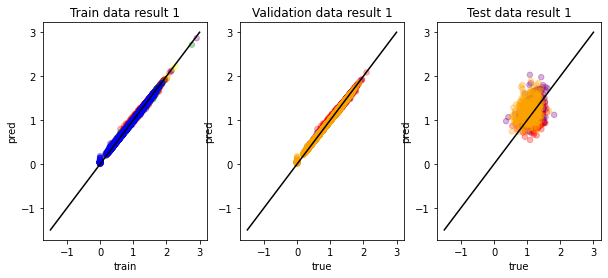

Epoch  28100 Train_loss:  0.013749253  Validation_loss:  0.014139032  Test_loss:  0.26386213
Epoch  28200 Train_loss:  0.013725502  Validation_loss:  0.0140653895  Test_loss:  0.264278
Epoch  28300 Train_loss:  0.013715665  Validation_loss:  0.014065593  Test_loss:  0.2640505
Epoch  28400 Train_loss:  0.013603476  Validation_loss:  0.013989753  Test_loss:  0.26383278
Epoch  28500 Train_loss:  0.013722358  Validation_loss:  0.014099897  Test_loss:  0.26349506
Epoch  28600 Train_loss:  0.01346836  Validation_loss:  0.013893323  Test_loss:  0.2635282
Epoch  28700 Train_loss:  0.013527498  Validation_loss:  0.013883875  Test_loss:  0.26372045
Epoch  28800 Train_loss:  0.0134383375  Validation_loss:  0.013744714  Test_loss:  0.2640288
Epoch  28900 Train_loss:  0.0135130985  Validation_loss:  0.013824208  Test_loss:  0.26347733
Epoch  29000 Train_loss:  0.013522386  Validation_loss:  0.013922609  Test_loss:  0.2633961


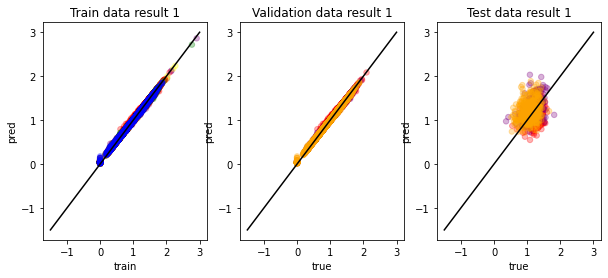

Epoch  29100 Train_loss:  0.013392081  Validation_loss:  0.013745012  Test_loss:  0.2634389
Epoch  29200 Train_loss:  0.013470485  Validation_loss:  0.01376498  Test_loss:  0.2635356
Epoch  29300 Train_loss:  0.013407589  Validation_loss:  0.013790581  Test_loss:  0.26333365
Epoch  29400 Train_loss:  0.01314081  Validation_loss:  0.0135092605  Test_loss:  0.26337674
Epoch  29500 Train_loss:  0.013282324  Validation_loss:  0.0136540495  Test_loss:  0.263118
Epoch  29600 Train_loss:  0.013181915  Validation_loss:  0.013525678  Test_loss:  0.26315394
Epoch  29700 Train_loss:  0.012942196  Validation_loss:  0.013262271  Test_loss:  0.26325545
Epoch  29800 Train_loss:  0.013010876  Validation_loss:  0.013338983  Test_loss:  0.26327398
Epoch  29900 Train_loss:  0.012978308  Validation_loss:  0.013297671  Test_loss:  0.26304966
Epoch  30000 Train_loss:  0.012984847  Validation_loss:  0.013261493  Test_loss:  0.26310912


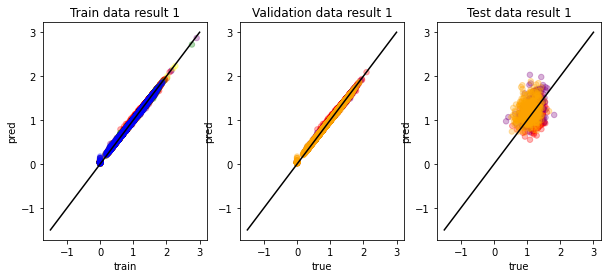

Epoch  30100 Train_loss:  0.013026394  Validation_loss:  0.013275268  Test_loss:  0.2633035
Epoch  30200 Train_loss:  0.013006001  Validation_loss:  0.013313155  Test_loss:  0.26274875
Epoch  30300 Train_loss:  0.013031404  Validation_loss:  0.013299184  Test_loss:  0.26299146
Epoch  30400 Train_loss:  0.012970849  Validation_loss:  0.01326865  Test_loss:  0.2628841
Epoch  30500 Train_loss:  0.012863299  Validation_loss:  0.01316268  Test_loss:  0.26250765
Epoch  30600 Train_loss:  0.012905795  Validation_loss:  0.013180399  Test_loss:  0.2624842
Epoch  30700 Train_loss:  0.012734691  Validation_loss:  0.013008833  Test_loss:  0.26292005
Epoch  30800 Train_loss:  0.012630082  Validation_loss:  0.012920099  Test_loss:  0.262879
Epoch  30900 Train_loss:  0.01267567  Validation_loss:  0.012925353  Test_loss:  0.2627822
Epoch  31000 Train_loss:  0.012606407  Validation_loss:  0.012891737  Test_loss:  0.26267174


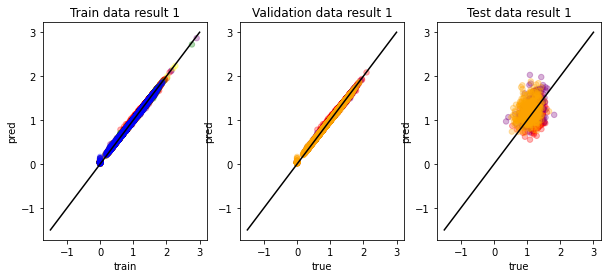

Epoch  31100 Train_loss:  0.013110228  Validation_loss:  0.013416223  Test_loss:  0.2617637
Epoch  31200 Train_loss:  0.01261765  Validation_loss:  0.012890566  Test_loss:  0.26243854
Epoch  31300 Train_loss:  0.012706497  Validation_loss:  0.012971976  Test_loss:  0.26238707
Epoch  31400 Train_loss:  0.012443397  Validation_loss:  0.01269098  Test_loss:  0.26284847
Epoch  31500 Train_loss:  0.012596846  Validation_loss:  0.012846037  Test_loss:  0.26227093
Epoch  31600 Train_loss:  0.012329917  Validation_loss:  0.012551787  Test_loss:  0.26246843
Epoch  31700 Train_loss:  0.0123118935  Validation_loss:  0.012610061  Test_loss:  0.2622669
Epoch  31800 Train_loss:  0.01243996  Validation_loss:  0.012676341  Test_loss:  0.26183432
Epoch  31900 Train_loss:  0.012472758  Validation_loss:  0.01274265  Test_loss:  0.2618075
Epoch  32000 Train_loss:  0.012503274  Validation_loss:  0.01279178  Test_loss:  0.2617157


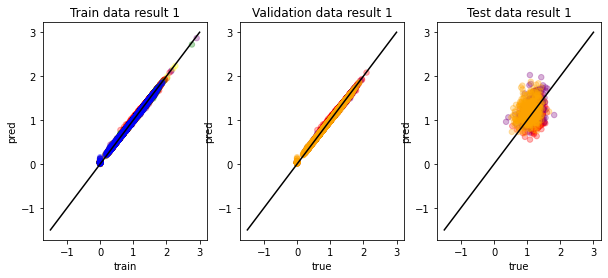

Epoch  32100 Train_loss:  0.012243961  Validation_loss:  0.012467367  Test_loss:  0.2619637
Epoch  32200 Train_loss:  0.012088809  Validation_loss:  0.0123429205  Test_loss:  0.26215994
Epoch  32300 Train_loss:  0.012234212  Validation_loss:  0.012457545  Test_loss:  0.26186994
Epoch  32400 Train_loss:  0.012389977  Validation_loss:  0.0126437405  Test_loss:  0.26161128
Epoch  32500 Train_loss:  0.011961417  Validation_loss:  0.012150485  Test_loss:  0.26199067
Epoch  32600 Train_loss:  0.012142458  Validation_loss:  0.012407162  Test_loss:  0.26195675
Epoch  32700 Train_loss:  0.012045632  Validation_loss:  0.0122435065  Test_loss:  0.26194882
Epoch  32800 Train_loss:  0.012002646  Validation_loss:  0.012245931  Test_loss:  0.26200286
Epoch  32900 Train_loss:  0.012185959  Validation_loss:  0.012352577  Test_loss:  0.26150346
Epoch  33000 Train_loss:  0.011875301  Validation_loss:  0.0120702535  Test_loss:  0.26210776


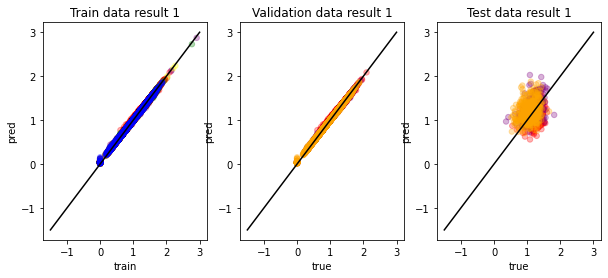

Epoch  33100 Train_loss:  0.012007144  Validation_loss:  0.012219781  Test_loss:  0.2615044
Epoch  33200 Train_loss:  0.011934736  Validation_loss:  0.012181397  Test_loss:  0.26169294
Epoch  33300 Train_loss:  0.011955698  Validation_loss:  0.012227514  Test_loss:  0.26139748
Epoch  33400 Train_loss:  0.012043642  Validation_loss:  0.012251286  Test_loss:  0.26146567
Epoch  33500 Train_loss:  0.011939228  Validation_loss:  0.012216964  Test_loss:  0.26135305
Epoch  33600 Train_loss:  0.011917461  Validation_loss:  0.012132082  Test_loss:  0.26129645
Epoch  33700 Train_loss:  0.011754669  Validation_loss:  0.011963046  Test_loss:  0.26146668
Epoch  33800 Train_loss:  0.012045279  Validation_loss:  0.012223507  Test_loss:  0.26095167
Epoch  33900 Train_loss:  0.011725188  Validation_loss:  0.011915925  Test_loss:  0.261279
Epoch  34000 Train_loss:  0.011836524  Validation_loss:  0.012025952  Test_loss:  0.26117444


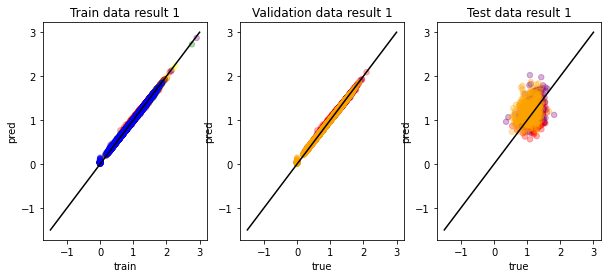

Epoch  34100 Train_loss:  0.011765482  Validation_loss:  0.011913504  Test_loss:  0.26162344
Epoch  34200 Train_loss:  0.011674621  Validation_loss:  0.011874389  Test_loss:  0.2610531
Epoch  34300 Train_loss:  0.011459416  Validation_loss:  0.011618725  Test_loss:  0.26132128
Epoch  34400 Train_loss:  0.011981684  Validation_loss:  0.01229631  Test_loss:  0.26054564
Epoch  34500 Train_loss:  0.01157975  Validation_loss:  0.011815515  Test_loss:  0.2606989
Epoch  34600 Train_loss:  0.011579254  Validation_loss:  0.011811647  Test_loss:  0.26074553
Epoch  34700 Train_loss:  0.011563388  Validation_loss:  0.011745361  Test_loss:  0.26083905
Epoch  34800 Train_loss:  0.011532079  Validation_loss:  0.011696888  Test_loss:  0.26058933
Epoch  34900 Train_loss:  0.011474915  Validation_loss:  0.01166588  Test_loss:  0.26084054
Epoch  35000 Train_loss:  0.011525457  Validation_loss:  0.011707135  Test_loss:  0.26070035


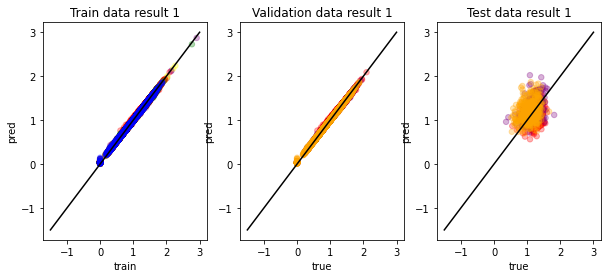

Epoch  35100 Train_loss:  0.011398996  Validation_loss:  0.011586193  Test_loss:  0.2605926
Epoch  35200 Train_loss:  0.011402881  Validation_loss:  0.011537146  Test_loss:  0.2606089
Epoch  35300 Train_loss:  0.01145566  Validation_loss:  0.01167515  Test_loss:  0.26058143
Epoch  35400 Train_loss:  0.011278822  Validation_loss:  0.01146186  Test_loss:  0.2608189
Epoch  35500 Train_loss:  0.011424121  Validation_loss:  0.011572451  Test_loss:  0.2604683
Epoch  35600 Train_loss:  0.011397117  Validation_loss:  0.011539168  Test_loss:  0.26059142
Epoch  35700 Train_loss:  0.011340398  Validation_loss:  0.011500123  Test_loss:  0.26041013
Epoch  35800 Train_loss:  0.011307919  Validation_loss:  0.011427827  Test_loss:  0.26062828
Epoch  35900 Train_loss:  0.011228064  Validation_loss:  0.011388827  Test_loss:  0.26023495
Epoch  36000 Train_loss:  0.011377696  Validation_loss:  0.011524736  Test_loss:  0.26045567


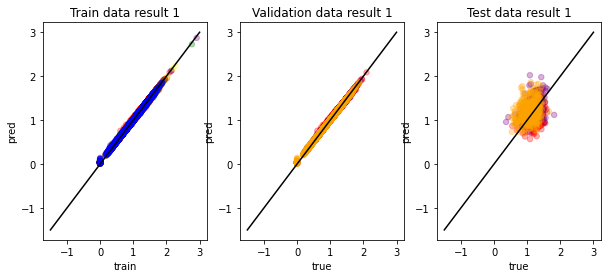

Epoch  36100 Train_loss:  0.011256317  Validation_loss:  0.011428765  Test_loss:  0.2603338
Epoch  36200 Train_loss:  0.011042721  Validation_loss:  0.011236539  Test_loss:  0.26039
Epoch  36300 Train_loss:  0.011109428  Validation_loss:  0.011320488  Test_loss:  0.26021087
Epoch  36400 Train_loss:  0.010989076  Validation_loss:  0.011143709  Test_loss:  0.26034188
Epoch  36500 Train_loss:  0.01103554  Validation_loss:  0.011154444  Test_loss:  0.26012486
Epoch  36600 Train_loss:  0.011053  Validation_loss:  0.011182654  Test_loss:  0.26025552
Epoch  36700 Train_loss:  0.011064127  Validation_loss:  0.011184864  Test_loss:  0.25995153
Epoch  36800 Train_loss:  0.0110552665  Validation_loss:  0.011185119  Test_loss:  0.25993732
Epoch  36900 Train_loss:  0.011041482  Validation_loss:  0.011186969  Test_loss:  0.26003504
Epoch  37000 Train_loss:  0.010894146  Validation_loss:  0.011058331  Test_loss:  0.26023006


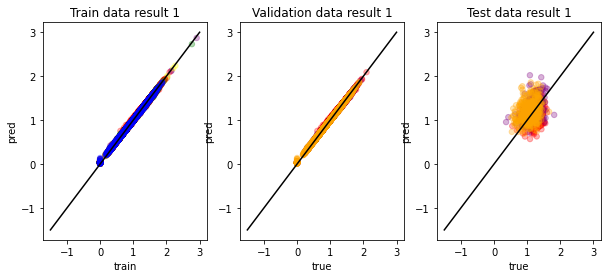

Epoch  37100 Train_loss:  0.011053294  Validation_loss:  0.011175889  Test_loss:  0.25980458
Epoch  37200 Train_loss:  0.010877085  Validation_loss:  0.011045196  Test_loss:  0.259934
Epoch  37300 Train_loss:  0.011182555  Validation_loss:  0.011421622  Test_loss:  0.25974736
Epoch  37400 Train_loss:  0.010859256  Validation_loss:  0.010991523  Test_loss:  0.26007006
Epoch  37500 Train_loss:  0.010836563  Validation_loss:  0.010952726  Test_loss:  0.26000977
Epoch  37600 Train_loss:  0.010775913  Validation_loss:  0.010944169  Test_loss:  0.2600942
Epoch  37700 Train_loss:  0.010777076  Validation_loss:  0.010931764  Test_loss:  0.25983226
Epoch  37800 Train_loss:  0.010826175  Validation_loss:  0.010992003  Test_loss:  0.259791
Epoch  37900 Train_loss:  0.010883075  Validation_loss:  0.010979697  Test_loss:  0.2597419
Epoch  38000 Train_loss:  0.010789064  Validation_loss:  0.010920852  Test_loss:  0.25956488


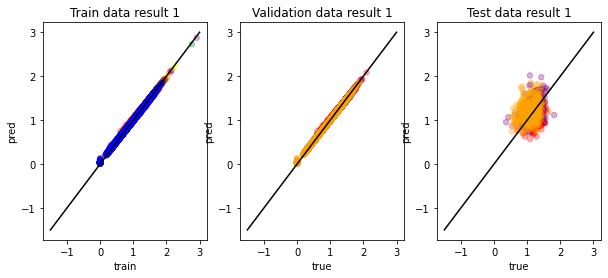

Epoch  38100 Train_loss:  0.010750585  Validation_loss:  0.010894603  Test_loss:  0.25986636
Epoch  38200 Train_loss:  0.010635729  Validation_loss:  0.010761474  Test_loss:  0.2597637
Epoch  38300 Train_loss:  0.010742758  Validation_loss:  0.010853716  Test_loss:  0.25919417
Epoch  38400 Train_loss:  0.010750166  Validation_loss:  0.010867048  Test_loss:  0.25948542
Epoch  38500 Train_loss:  0.010489727  Validation_loss:  0.010613741  Test_loss:  0.25969857
Epoch  38600 Train_loss:  0.010641619  Validation_loss:  0.010756576  Test_loss:  0.25953165
Epoch  38700 Train_loss:  0.010702743  Validation_loss:  0.010846659  Test_loss:  0.25926778
Epoch  38800 Train_loss:  0.010510896  Validation_loss:  0.01065028  Test_loss:  0.2594354
Epoch  38900 Train_loss:  0.010731962  Validation_loss:  0.010909565  Test_loss:  0.2591122
Epoch  39000 Train_loss:  0.010610075  Validation_loss:  0.010790344  Test_loss:  0.25914916


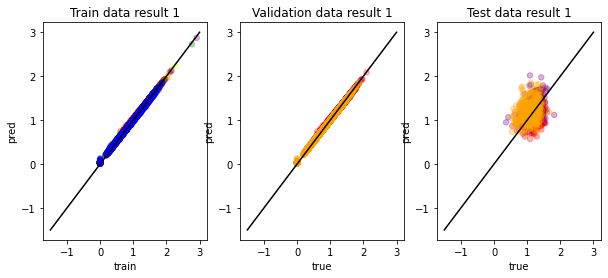

Epoch  39100 Train_loss:  0.010566066  Validation_loss:  0.010733331  Test_loss:  0.25940594
Epoch  39200 Train_loss:  0.010761312  Validation_loss:  0.010996596  Test_loss:  0.258937
Epoch  39300 Train_loss:  0.0105483495  Validation_loss:  0.010750893  Test_loss:  0.25913393
Epoch  39400 Train_loss:  0.010412109  Validation_loss:  0.010519879  Test_loss:  0.25930128
Epoch  39500 Train_loss:  0.010595604  Validation_loss:  0.0107646445  Test_loss:  0.25892636
Epoch  39600 Train_loss:  0.010380263  Validation_loss:  0.010486789  Test_loss:  0.25897717
Epoch  39700 Train_loss:  0.01057976  Validation_loss:  0.010699495  Test_loss:  0.2589937
Epoch  39800 Train_loss:  0.010385232  Validation_loss:  0.010546149  Test_loss:  0.2588837
Epoch  39900 Train_loss:  0.010508758  Validation_loss:  0.010567666  Test_loss:  0.25904638
Epoch  40000 Train_loss:  0.010354387  Validation_loss:  0.010476801  Test_loss:  0.25895804


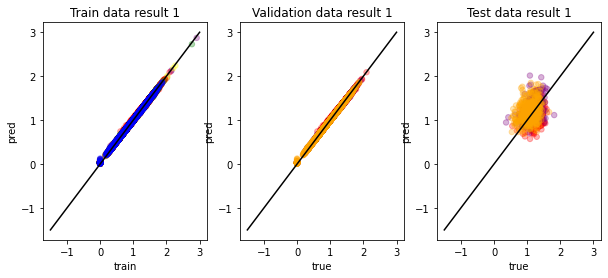

Epoch  40100 Train_loss:  0.010366135  Validation_loss:  0.010469814  Test_loss:  0.2587797
Epoch  40200 Train_loss:  0.010357442  Validation_loss:  0.010501796  Test_loss:  0.25874063
Epoch  40300 Train_loss:  0.01025769  Validation_loss:  0.010396195  Test_loss:  0.25879604
Epoch  40400 Train_loss:  0.010353989  Validation_loss:  0.010485931  Test_loss:  0.25893086
Epoch  40500 Train_loss:  0.010222245  Validation_loss:  0.010308648  Test_loss:  0.2589204
Epoch  40600 Train_loss:  0.010366013  Validation_loss:  0.010495293  Test_loss:  0.25850996
Epoch  40700 Train_loss:  0.010290297  Validation_loss:  0.01043032  Test_loss:  0.2586671
Epoch  40800 Train_loss:  0.010236794  Validation_loss:  0.010293412  Test_loss:  0.25874147
Epoch  40900 Train_loss:  0.0103119975  Validation_loss:  0.010375266  Test_loss:  0.25877243
Epoch  41000 Train_loss:  0.010201647  Validation_loss:  0.010282932  Test_loss:  0.25856072


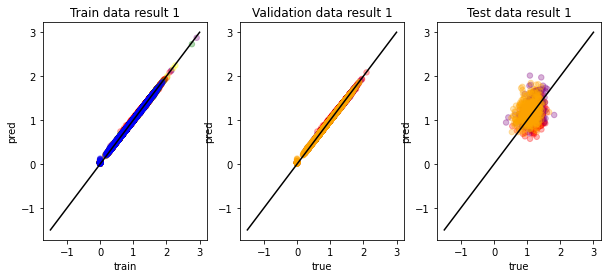

Epoch  41100 Train_loss:  0.010302016  Validation_loss:  0.010428129  Test_loss:  0.25853625
Epoch  41200 Train_loss:  0.01017003  Validation_loss:  0.010185204  Test_loss:  0.25874057
Epoch  41300 Train_loss:  0.010028269  Validation_loss:  0.0101214005  Test_loss:  0.2587188
Epoch  41400 Train_loss:  0.010098477  Validation_loss:  0.010175323  Test_loss:  0.25852266
Epoch  41500 Train_loss:  0.010103397  Validation_loss:  0.0101849735  Test_loss:  0.25838795
Epoch  41600 Train_loss:  0.010114997  Validation_loss:  0.010163121  Test_loss:  0.25840604
Epoch  41700 Train_loss:  0.010175455  Validation_loss:  0.010288324  Test_loss:  0.25825936
Epoch  41800 Train_loss:  0.010106728  Validation_loss:  0.010308673  Test_loss:  0.25841308
Epoch  41900 Train_loss:  0.010141176  Validation_loss:  0.0102650095  Test_loss:  0.25819376
Epoch  42000 Train_loss:  0.009913721  Validation_loss:  0.009974429  Test_loss:  0.25861445


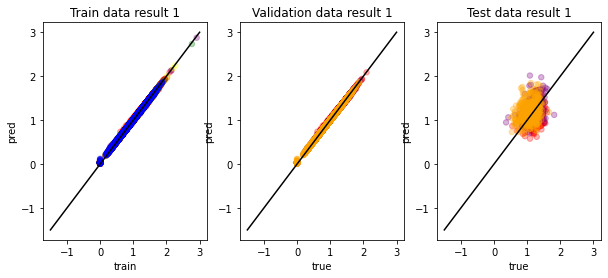

Epoch  42100 Train_loss:  0.009872956  Validation_loss:  0.010019911  Test_loss:  0.25836486
Epoch  42200 Train_loss:  0.010107016  Validation_loss:  0.010135625  Test_loss:  0.25818235
Epoch  42300 Train_loss:  0.01000332  Validation_loss:  0.010082726  Test_loss:  0.25816107
Epoch  42400 Train_loss:  0.0099629415  Validation_loss:  0.010063402  Test_loss:  0.25808248
Epoch  42500 Train_loss:  0.009882315  Validation_loss:  0.00999131  Test_loss:  0.2582115
Epoch  42600 Train_loss:  0.010054654  Validation_loss:  0.010082127  Test_loss:  0.25820342
Epoch  42700 Train_loss:  0.009964889  Validation_loss:  0.010062442  Test_loss:  0.25807086
Epoch  42800 Train_loss:  0.010046656  Validation_loss:  0.010159187  Test_loss:  0.25778976
Epoch  42900 Train_loss:  0.009916702  Validation_loss:  0.010041997  Test_loss:  0.25790074
Epoch  43000 Train_loss:  0.0100472225  Validation_loss:  0.010129988  Test_loss:  0.25784546


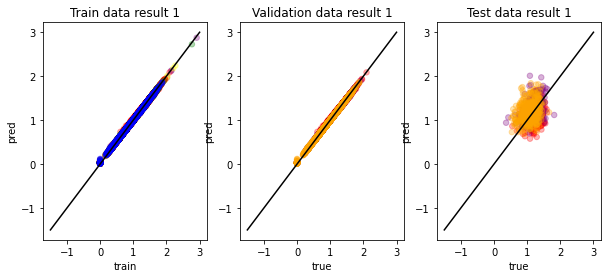

Epoch  43100 Train_loss:  0.009754694  Validation_loss:  0.009775515  Test_loss:  0.25779656
Epoch  43200 Train_loss:  0.009832785  Validation_loss:  0.00994328  Test_loss:  0.25792733
Epoch  43300 Train_loss:  0.009752279  Validation_loss:  0.009815854  Test_loss:  0.25805336
Epoch  43400 Train_loss:  0.009918069  Validation_loss:  0.010050726  Test_loss:  0.25770724
Epoch  43500 Train_loss:  0.009940535  Validation_loss:  0.009995933  Test_loss:  0.25791404
Epoch  43600 Train_loss:  0.009939581  Validation_loss:  0.01003071  Test_loss:  0.25763324
Epoch  43700 Train_loss:  0.009781877  Validation_loss:  0.009874946  Test_loss:  0.257628
Epoch  43800 Train_loss:  0.009620303  Validation_loss:  0.009695588  Test_loss:  0.25777608
Epoch  43900 Train_loss:  0.009735423  Validation_loss:  0.009801564  Test_loss:  0.257703
Epoch  44000 Train_loss:  0.009682675  Validation_loss:  0.009801677  Test_loss:  0.25762624


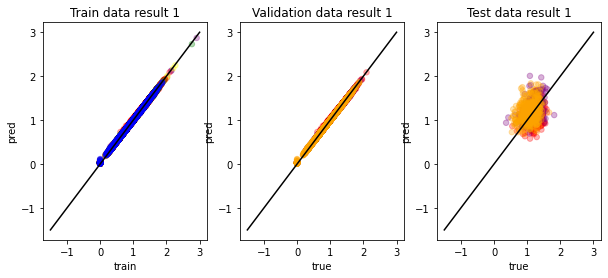

Epoch  44100 Train_loss:  0.009828606  Validation_loss:  0.009981459  Test_loss:  0.25739285
Epoch  44200 Train_loss:  0.009577855  Validation_loss:  0.009618021  Test_loss:  0.2577871
Epoch  44300 Train_loss:  0.009744442  Validation_loss:  0.009818965  Test_loss:  0.2575031
Epoch  44400 Train_loss:  0.009595794  Validation_loss:  0.009701661  Test_loss:  0.2575289
Epoch  44500 Train_loss:  0.009751845  Validation_loss:  0.009874139  Test_loss:  0.25740096
Epoch  44600 Train_loss:  0.00976375  Validation_loss:  0.009854557  Test_loss:  0.25718853
Epoch  44700 Train_loss:  0.009680654  Validation_loss:  0.009716177  Test_loss:  0.25738916
Epoch  44800 Train_loss:  0.009397616  Validation_loss:  0.009472682  Test_loss:  0.25757316
Epoch  44900 Train_loss:  0.009476989  Validation_loss:  0.009566891  Test_loss:  0.25754824
Epoch  45000 Train_loss:  0.009575558  Validation_loss:  0.009674457  Test_loss:  0.25732872


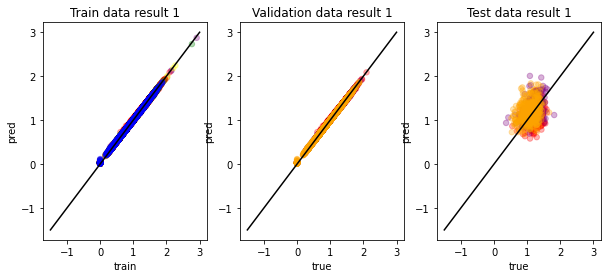

Epoch  45100 Train_loss:  0.009578939  Validation_loss:  0.009671587  Test_loss:  0.25714874
Epoch  45200 Train_loss:  0.009478012  Validation_loss:  0.009531111  Test_loss:  0.25737095
Epoch  45300 Train_loss:  0.009582799  Validation_loss:  0.009632477  Test_loss:  0.25721788
Epoch  45400 Train_loss:  0.00951202  Validation_loss:  0.0095769875  Test_loss:  0.25723746
Epoch  45500 Train_loss:  0.009492045  Validation_loss:  0.0095449  Test_loss:  0.25712708
Epoch  45600 Train_loss:  0.009460078  Validation_loss:  0.009578505  Test_loss:  0.25718516
Epoch  45700 Train_loss:  0.009453485  Validation_loss:  0.009514707  Test_loss:  0.25716278
Epoch  45800 Train_loss:  0.009355109  Validation_loss:  0.009426588  Test_loss:  0.25734437
Epoch  45900 Train_loss:  0.009566656  Validation_loss:  0.009560339  Test_loss:  0.25706625
Epoch  46000 Train_loss:  0.009427735  Validation_loss:  0.009486664  Test_loss:  0.25712118


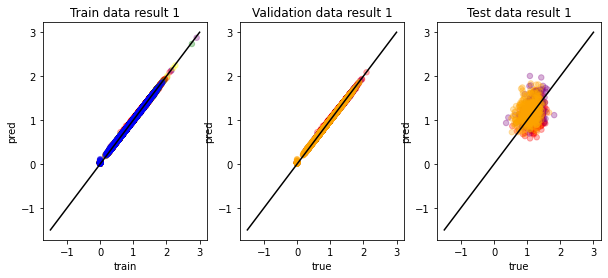

Epoch  46100 Train_loss:  0.00955489  Validation_loss:  0.009714118  Test_loss:  0.25691214
Epoch  46200 Train_loss:  0.009368406  Validation_loss:  0.009374976  Test_loss:  0.25714776
Epoch  46300 Train_loss:  0.009337068  Validation_loss:  0.009380534  Test_loss:  0.25707972
Epoch  46400 Train_loss:  0.0094007645  Validation_loss:  0.009486281  Test_loss:  0.2568956
Epoch  46500 Train_loss:  0.00937482  Validation_loss:  0.009490145  Test_loss:  0.25692847
Epoch  46600 Train_loss:  0.0092880335  Validation_loss:  0.0093621155  Test_loss:  0.25696686
Epoch  46700 Train_loss:  0.009436873  Validation_loss:  0.009544308  Test_loss:  0.2567994
Epoch  46800 Train_loss:  0.009261917  Validation_loss:  0.009282892  Test_loss:  0.25693312
Epoch  46900 Train_loss:  0.009431742  Validation_loss:  0.009571399  Test_loss:  0.25661492
Epoch  47000 Train_loss:  0.009350377  Validation_loss:  0.009408476  Test_loss:  0.2568213


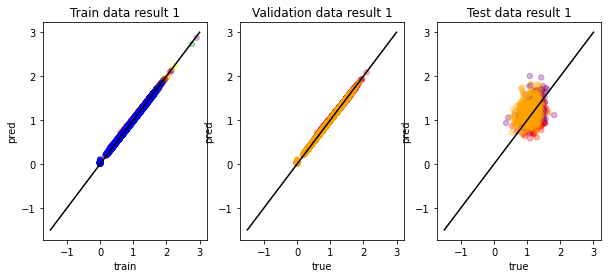

Epoch  47100 Train_loss:  0.009334867  Validation_loss:  0.009377863  Test_loss:  0.25666755
Epoch  47200 Train_loss:  0.00930258  Validation_loss:  0.009398568  Test_loss:  0.2568381
Epoch  47300 Train_loss:  0.009206974  Validation_loss:  0.009284035  Test_loss:  0.2566331
Epoch  47400 Train_loss:  0.009333333  Validation_loss:  0.009412301  Test_loss:  0.25666758
Epoch  47500 Train_loss:  0.00919044  Validation_loss:  0.0092011895  Test_loss:  0.25677544
Epoch  47600 Train_loss:  0.009183758  Validation_loss:  0.009259807  Test_loss:  0.25657144
Epoch  47700 Train_loss:  0.009252284  Validation_loss:  0.009310418  Test_loss:  0.25656578
Epoch  47800 Train_loss:  0.009370964  Validation_loss:  0.009413055  Test_loss:  0.2563929
Epoch  47900 Train_loss:  0.009245682  Validation_loss:  0.009297345  Test_loss:  0.25646207
Epoch  48000 Train_loss:  0.009355373  Validation_loss:  0.009499474  Test_loss:  0.25634083


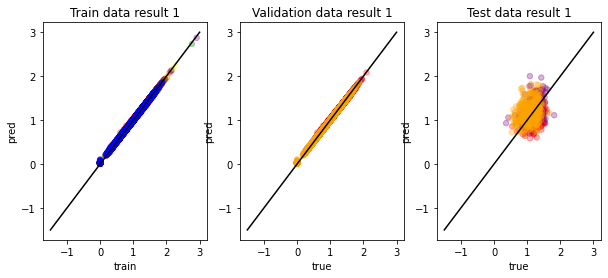

Epoch  48100 Train_loss:  0.009326272  Validation_loss:  0.009385227  Test_loss:  0.2563542
Epoch  48200 Train_loss:  0.009074314  Validation_loss:  0.009127142  Test_loss:  0.25648096
Epoch  48300 Train_loss:  0.008909903  Validation_loss:  0.008963404  Test_loss:  0.2565003
Epoch  48400 Train_loss:  0.00924997  Validation_loss:  0.009295542  Test_loss:  0.25643727
Epoch  48500 Train_loss:  0.009162183  Validation_loss:  0.009281779  Test_loss:  0.25634634
Epoch  48600 Train_loss:  0.009116881  Validation_loss:  0.009153102  Test_loss:  0.25641724
Epoch  48700 Train_loss:  0.008871748  Validation_loss:  0.008968065  Test_loss:  0.25641838
Epoch  48800 Train_loss:  0.009168616  Validation_loss:  0.0092321  Test_loss:  0.25622657
Epoch  48900 Train_loss:  0.009131576  Validation_loss:  0.00921531  Test_loss:  0.25628844
Epoch  49000 Train_loss:  0.009124313  Validation_loss:  0.009178891  Test_loss:  0.25617653


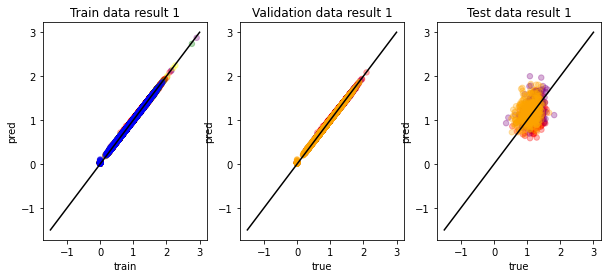

Epoch  49100 Train_loss:  0.008996652  Validation_loss:  0.00903709  Test_loss:  0.25622076
Epoch  49200 Train_loss:  0.008963716  Validation_loss:  0.009020168  Test_loss:  0.25617927
Epoch  49300 Train_loss:  0.009001025  Validation_loss:  0.009083705  Test_loss:  0.25614408
Epoch  49400 Train_loss:  0.009038809  Validation_loss:  0.009060137  Test_loss:  0.256003
Epoch  49500 Train_loss:  0.009043216  Validation_loss:  0.009119246  Test_loss:  0.25614336
Epoch  49600 Train_loss:  0.008935109  Validation_loss:  0.009021871  Test_loss:  0.25610173
Epoch  49700 Train_loss:  0.008953851  Validation_loss:  0.009052736  Test_loss:  0.25610346
Epoch  49800 Train_loss:  0.008933266  Validation_loss:  0.00897706  Test_loss:  0.25597182
Epoch  49900 Train_loss:  0.008934428  Validation_loss:  0.008983683  Test_loss:  0.2559562


In [38]:
num_epochs = 50000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)